In [2]:
# Import library for network analysis and visualisation
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

## Set up network

In [3]:
# Read csv files
df = pd.read_csv(os.path.join('data', 'BACI_HS92_V202401b','BACI_HS92_Y2022_V202401b.csv')) # 2022 data
country_df = pd.read_csv(os.path.join('data', 'BACI_HS92_V202401b','country_codes_V202401b.csv')) # country codes
product_df = pd.read_csv(os.path.join('data', 'BACI_HS92_V202401b','product_codes_HS92_V202401b.csv')) # product codes
df.head()

t  i   j       k       v              q
0  2022  4  20  210610   0.392          0.002
1  2022  4  20  210690   0.068          0.001
2  2022  4  20  271000   6.233          8.103
3  2022  4  20  843131   0.352          0.022
4  2022  4  24   71332  35.025         25.060

In [4]:
# From readme.txt

# Content:
# Trade flows at the year - exporter - importer - product level.
# Products in Harmonized System 6-digit nomenclature.
# Values in thousand USD and quantities in metric tons.

# List of Variables:
# t: year
# i: exporter
# j: importer
# k: product
# v: value ('000 USD)
# q: quantity (metric tons)

In [5]:
# Aggregate sum of trade values only
df_agg = df.groupby(['i', 'j']).sum().reset_index()
df_agg = df_agg[['i', 'j', 'v']]
df_agg.rename(columns={'i': 'exporter', 'j': 'importer', 'v': 'value'}, inplace=True)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30841 entries, 0 to 30840
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   exporter  30841 non-null  int64  
 1   importer  30841 non-null  int64  
 2   value     30841 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 723.0 KB


### Build directed network graph

In [6]:
G = nx.DiGraph()

# Add nodes and country name as node attribute
G.add_nodes_from(country_df['country_code'])
country_code_dict = dict(zip(country_df['country_code'], country_df['country_name']))
nx.set_node_attributes(G, country_code_dict, 'country_name')

# Add edge and attributes
for _, row in df_agg.iterrows():
    G.add_weighted_edges_from([(row['exporter'], row['importer'], row['value'])])

In [7]:
# Sense check
print("Number of nodes in G: ", G.number_of_nodes())
print("Number of edges in G: ", G.number_of_edges())
print("Number of countries in the country df: ", len(country_df))
print("Number of lines in the aggregated df: ", len(df_agg))

Number of nodes in G:  238
Number of edges in G:  30841
Number of countries in the country df:  238
Number of lines in the aggregated df:  30841


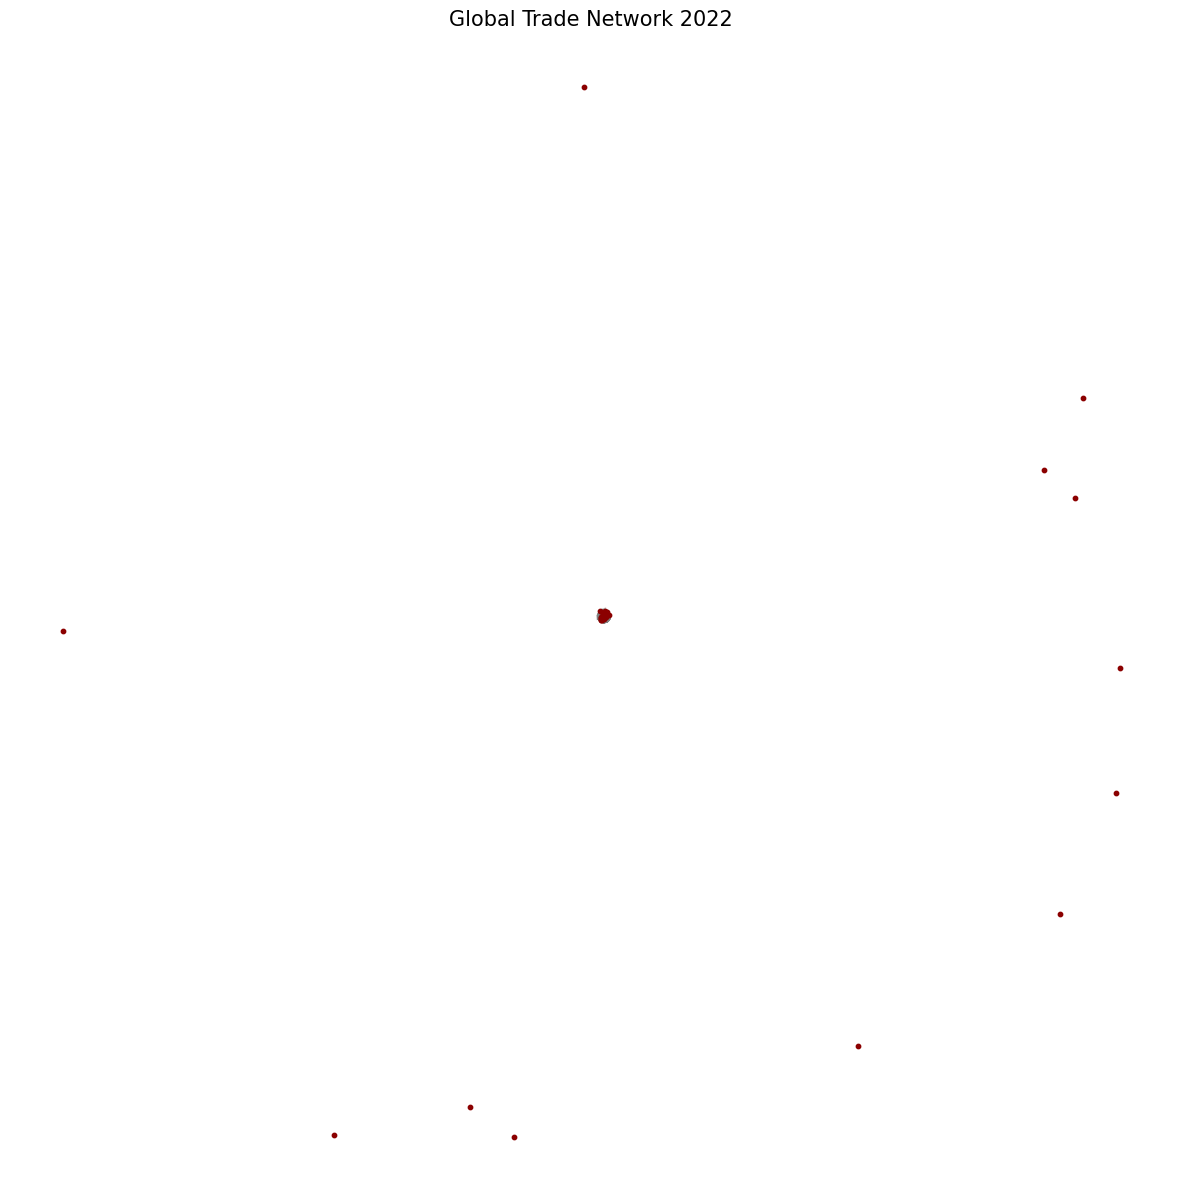

In [8]:
# Visualise the network

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(15,15))

# plot largest connected components
nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color='darkred',
                       node_size=10,
                       ax=ax,
                      )
ax.axis('off')
ax.set_title('Global Trade Network 2022', fontsize=15)

plt.show()

### Connected Components

In [9]:
# Connected components
connected_components = list(nx.weakly_connected_components(G))
connected_components_lengths = [len(component) for component in connected_components]

print("Number of connected components (weak): ", len(connected_components))
print("Lengths of connected components: ", connected_components_lengths)

Number of connected components (weak):  13
Lengths of connected components:  [226, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
# Which 12 countries have no trade partners?
countries_no_trade = [country for country in G.nodes() if G.out_degree(country) == 0] + [country for country in G.nodes() if G.in_degree(country) == 0]
countries_no_trade = list(set(countries_no_trade)) # dedup
countries_no_trade_name = [country_code_dict[country] for country in countries_no_trade] # get name

print("Number of countries with no trade partners: ", len(countries_no_trade))
print("Countries with no trade partners: ", pd.DataFrame(countries_no_trade_name, columns=['Country']))
# These are defunct countries and can be safely removed

G.remove_nodes_from(countries_no_trade) # Remove countries from G that are in countries_no_trade

Number of countries with no trade partners:  12
Countries with no trade partners:                                       Country
0                            Sudan (...2011)
1   Southern African Customs Union (...1999)
2                   Czechoslovakia (...1992)
3                             USSR (...1990)
4                  Mayotte (Overseas France)
5                      US Misc. Pacific Isds
6             Netherlands Antilles (...2010)
7             Dem. Rep. of Germany (...1990)
8             Fed. Rep. of Germany (...1990)
9                           Europe EFTA, nes
10              Belgium-Luxembourg (...1998)
11           Serbia and Montenegro (...2005)


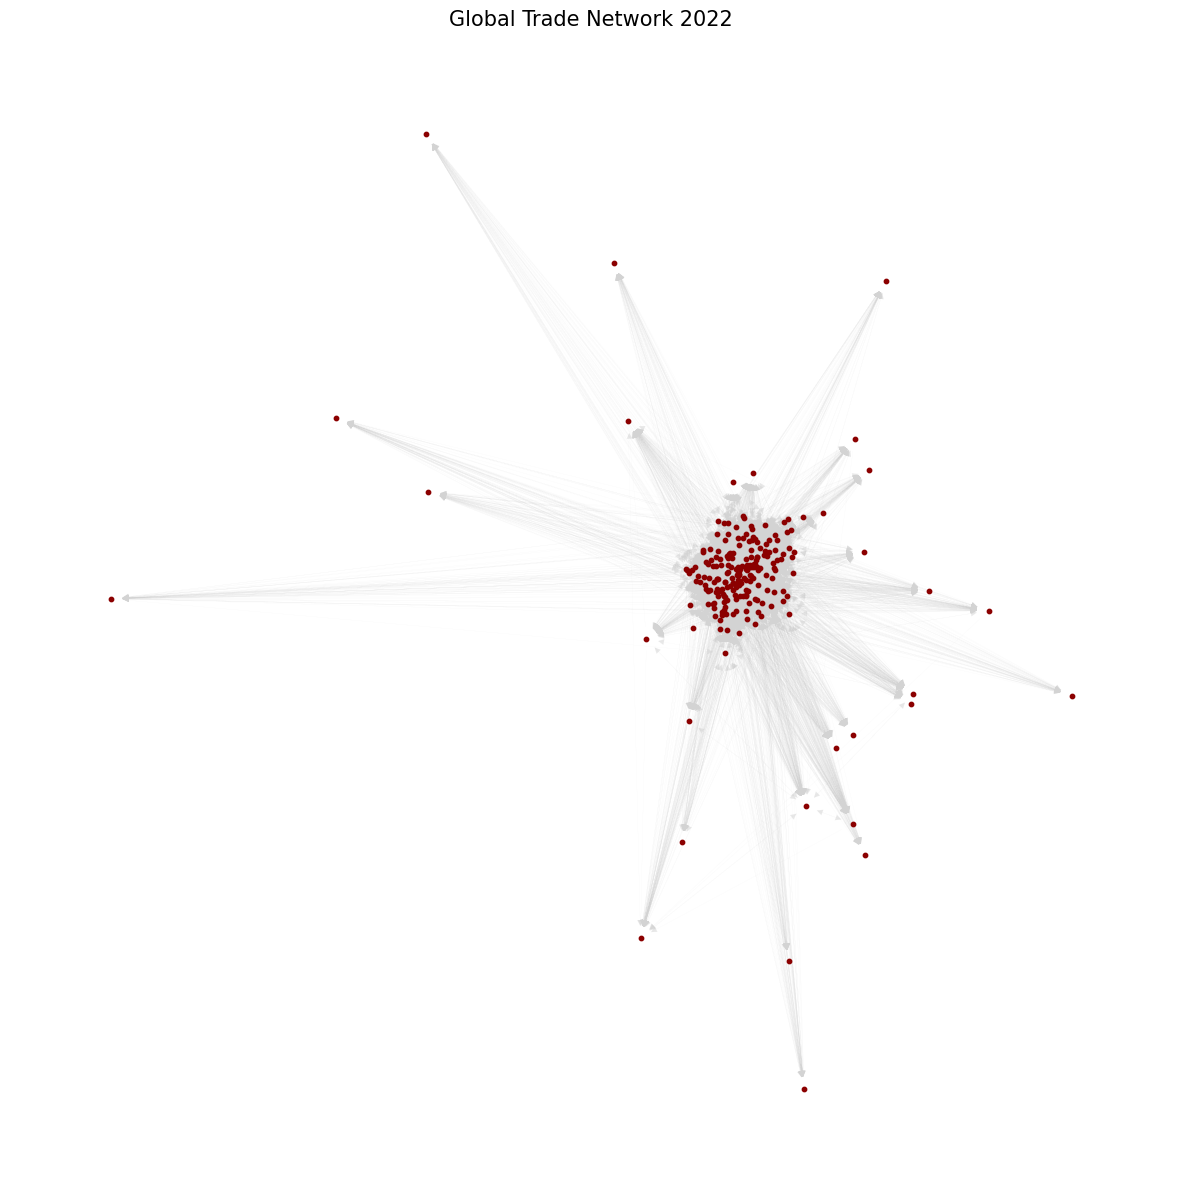

In [11]:
# Visualise the network

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(15,15))

# plot largest connected components
nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='lightgray',
                       width=0.05,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color='darkred',
                       node_size=10,
                       ax=ax)
ax.axis('off')
ax.set_title('Global Trade Network 2022', fontsize=15)

plt.show()

## Analyse network

### Degree distribution

In [12]:
# Calculate in and out degree for each node and add as node attributes

in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())

nx.set_node_attributes(G, in_degree_dict, 'in_degree')
nx.set_node_attributes(G, out_degree_dict, 'out_degree')

in_deg_list=[(i[1]['in_degree']) for i in G.nodes(data=True)]
out_deg_list=[(i[1]['out_degree']) for i in G.nodes(data=True)]

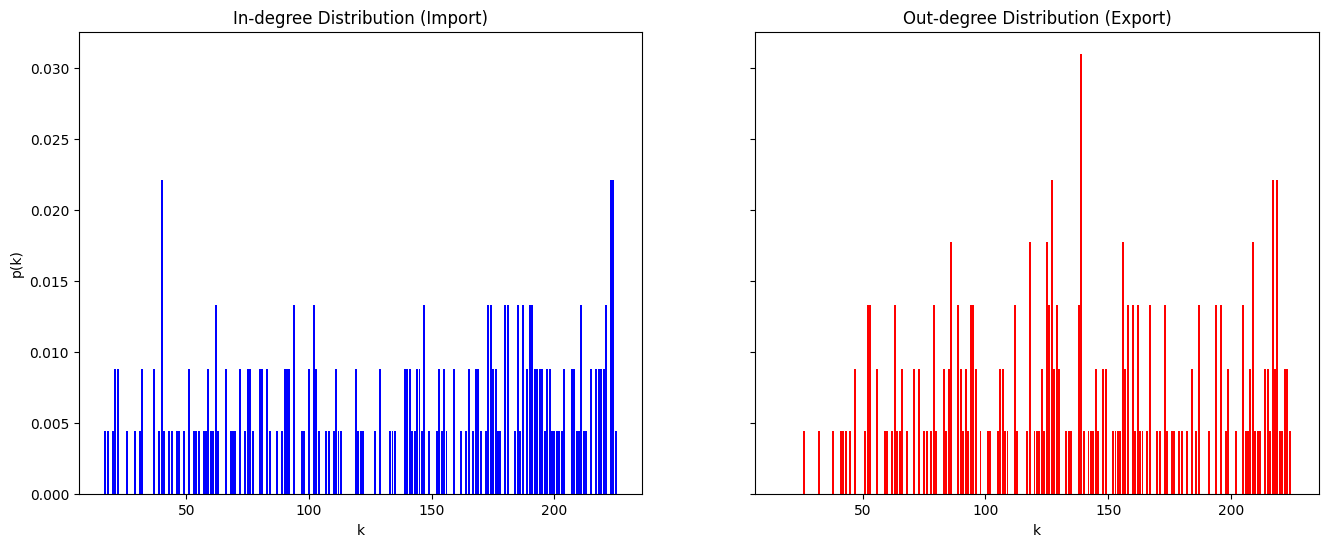

In [13]:
# Probability of in-degrees 
degree_values_in = sorted(set(in_deg_list)) # k
probability_in = [round(list(in_deg_list).count(i)/float(nx.number_of_nodes(G)),4) for i in degree_values_in]  # p(k)
df_in = pd.DataFrame({'k':degree_values_in,'p(k)':probability_in})

# Probability of out-degrees
degree_values_out = sorted(set(out_deg_list)) # k
probability_out = [round(list(out_deg_list).count(i)/float(nx.number_of_nodes(G)),4) for i in degree_values_out]  # p(k)
df_out = pd.DataFrame({'k':degree_values_out,'p(k)':probability_out})

# Graph deg dist (unweighted)
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True,sharex=True)

ax[0].bar(degree_values_in,probability_in,color="blue")
ax[0].set_title('In-degree Distribution (Import)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('p(k)')

ax[1].bar(degree_values_out,probability_out,color="red")
ax[1].set_title('Out-degree Distribution (Export)')
ax[1].set_xlabel('k')
# ax[1].set_ylabel('p(k)')

plt.show()

Top countries by unweighted degree (many trade partners)

In [14]:
# Top 10 importers by degree
importer_degree_df = pd.DataFrame.from_dict(nx.in_degree_centrality(G), orient='index', columns=['degree_centrality_in'])
importer_degree_df = importer_degree_df.sort_values(by='degree_centrality_in', ascending=False).reset_index()
importer_degree_df['country_name'] = importer_degree_df['index'].map(country_code_dict)
importer_degree_df = importer_degree_df[['country_name', 'degree_centrality_in']]
importer_degree_df.head(10)

country_name  degree_centrality_in
0         Czechia              1.000000
1         Ireland              0.995556
2        Slovenia              0.995556
3           Spain              0.995556
4          France              0.995556
5          Poland              0.995556
6    South Africa              0.991111
7  United Kingdom              0.991111
8          Sweden              0.991111
9        Thailand              0.991111

In [15]:
# Degree centrality out-degree
exporter_degree_df = pd.DataFrame.from_dict(nx.out_degree_centrality(G), orient='index', columns=['degree_centrality_out'])
exporter_degree_df = exporter_degree_df.sort_values(by='degree_centrality_out', ascending=False).reset_index()
exporter_degree_df['country_name'] = exporter_degree_df['index'].map(country_code_dict)
exporter_degree_df = exporter_degree_df[['country_name', 'degree_centrality_out']]
exporter_degree_df.head(10)

country_name  degree_centrality_out
0     Netherlands               0.995556
1  United Kingdom               0.991111
2         Germany               0.991111
3         Belgium               0.986667
4          Brazil               0.986667
5           Italy               0.982222
6   Rep. of Korea               0.977778
7     Switzerland               0.973333
8         Türkiye               0.973333
9          France               0.973333

Top countries by Weighted Degree (volume traded)

In [16]:
# Top 10 importers by weighted degree
importer_degree_w = dict(G.in_degree(weight='weight')) # weighted
nx.set_node_attributes(G, importer_degree_w, 'in_degree_w') # Add attribute

importer_degree_w_df = pd.DataFrame.from_dict(importer_degree_w, orient='index', columns=['degree_w'])
importer_degree_w_df = importer_degree_w_df.sort_values(by='degree_w', ascending=False).reset_index()
importer_degree_w_df['country_name'] = importer_degree_w_df['index'].map(country_code_dict)
importer_degree_w_df = importer_degree_w_df[['country_name', 'degree_w']]
importer_degree_w_df.head(10)


country_name      degree_w
0             USA  3.118563e+09
1           China  2.033335e+09
2         Germany  1.490754e+09
3           Japan  8.193351e+08
4          France  7.985656e+08
5     Netherlands  7.697236e+08
6  United Kingdom  7.376067e+08
7           India  7.242388e+08
8           Italy  6.712200e+08
9   Rep. of Korea  6.663926e+08

In [17]:
# Degree distribution for exporters
exporter_degree_w = dict(G.out_degree(weight='weight')) # weighted
nx.set_node_attributes(G, importer_degree_w, 'out_degree_w') # Add attribute

exporter_degree_w_df = pd.DataFrame.from_dict(exporter_degree_w, orient='index', columns=['degree_w'])
exporter_degree_w_df = exporter_degree_w_df.sort_values(by='degree_w', ascending=False).reset_index()
exporter_degree_w_df['country_name'] = exporter_degree_w_df['index'].map(country_code_dict)
exporter_degree_w_df = exporter_degree_w_df[['country_name', 'degree_w']]
exporter_degree_w_df.head(10)


country_name      degree_w
0          China  3.609472e+09
1            USA  1.953003e+09
2        Germany  1.600516e+09
3          Japan  7.278390e+08
4  Rep. of Korea  7.049456e+08
5    Netherlands  6.738880e+08
6          Italy  6.336890e+08
7         France  6.078372e+08
8         Canada  5.839381e+08
9         Mexico  5.485914e+08

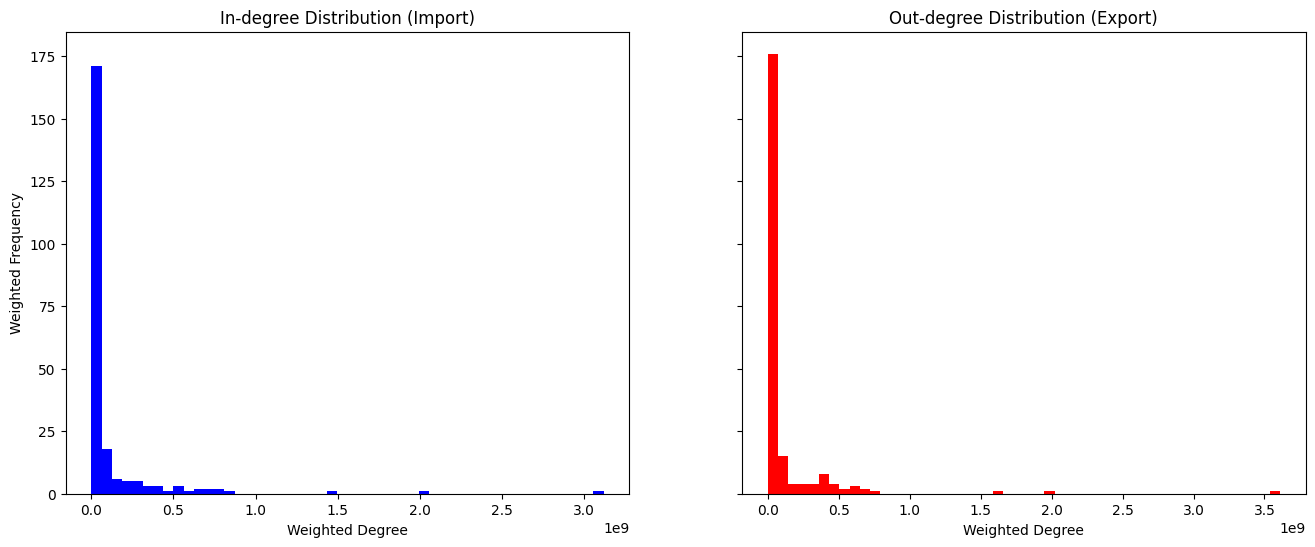

In [18]:
# Plot degree distribution for in-degree and out-degree (weighted)

fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)

ax[0].hist(list(importer_degree_w.values()), bins=50, color='blue')
ax[0].set_title('In-degree Distribution (Import)')
ax[0].set_xlabel('Weighted Degree')
ax[0].set_ylabel('Weighted Frequency')

ax[1].hist(list(exporter_degree_w.values()), bins=50, color='red')
ax[1].set_title('Out-degree Distribution (Export)')
ax[1].set_xlabel('Weighted Degree')
# ax[1].set_ylabel('Weighted Frequency')

plt.show()


### Trade Influence

In [19]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality') # Add attribute

betweenness_centrality_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness_centrality'])
betweenness_centrality_df = betweenness_centrality_df.sort_values(by='betweenness_centrality', ascending=False).reset_index()
betweenness_centrality_df['country_name'] = betweenness_centrality_df['index'].map(country_code_dict)
betweenness_centrality_df = betweenness_centrality_df[['country_name', 'betweenness_centrality']]
betweenness_centrality_df.head(10)

country_name  betweenness_centrality
0        United Kingdom                0.008399
1               Germany                0.008305
2           Netherlands                0.008139
3                   USA                0.007663
4                France                0.007645
5  United Arab Emirates                0.007550
6               Belgium                0.007494
7         Rep. of Korea                0.007463
8                Brazil                0.007358
9                 Spain                0.007265

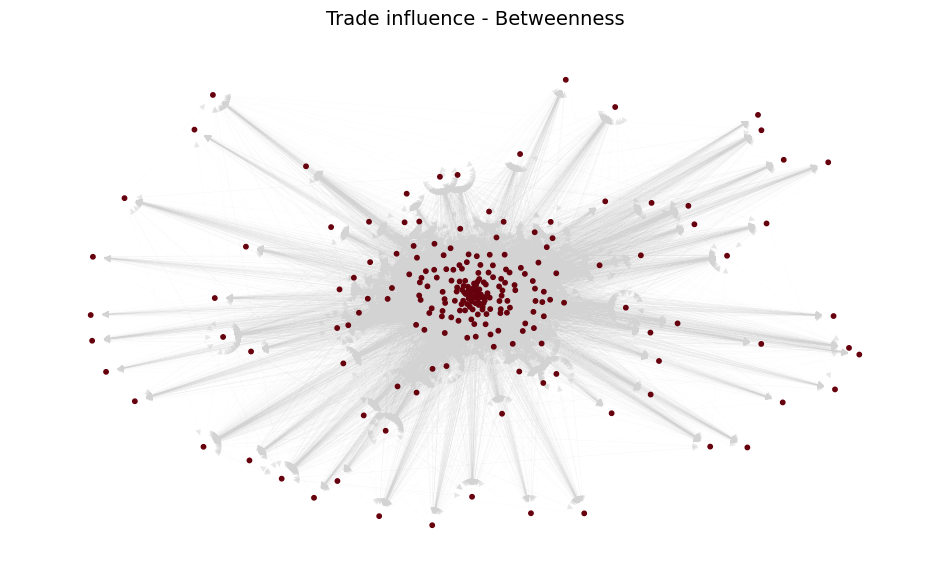

In [30]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

pos = nx.spring_layout(G, k=20)

norm = plt.Normalize(min(betweenness_centrality), max(betweenness_centrality))
node_colors = [cm.Reds_r(norm(G.nodes[node]['betweenness_centrality'])) for node in G.nodes()]

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='lightgray',
                       width=0.05,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color=node_colors,
                       node_size=10,
                       ax=ax)
    
plt.axis('off')
plt.title('Trade influence - Betweenness', fontsize=14)
plt.show()

In [23]:
# PageRank
pagerank = nx.pagerank(G)
nx.set_node_attributes(G, pagerank, 'pagerank') # Add attribute

pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
pagerank_df = pagerank_df.sort_values(by='pagerank', ascending=False).reset_index()
pagerank_df['country_name'] = pagerank_df['index'].map(country_code_dict)
pagerank_df = pagerank_df[['country_name', 'pagerank']]
pagerank_df.head(10)

country_name  pagerank
0             USA  0.105124
1           China  0.070168
2         Germany  0.053461
3          France  0.031708
4     Netherlands  0.028779
5           India  0.028072
6  United Kingdom  0.026494
7           Italy  0.025464
8           Japan  0.025176
9          Canada  0.023092

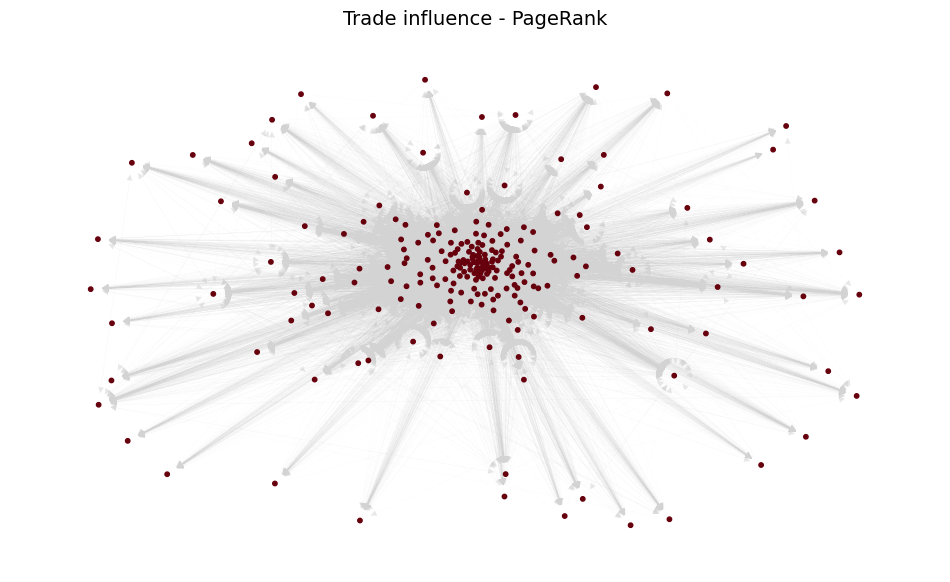

In [31]:
pos = nx.spring_layout(G, k=20)

norm = plt.Normalize(min(pagerank), max(pagerank))
node_colors = [cm.Reds_r(norm(G.nodes[node]['pagerank'])) for node in G.nodes()]

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='lightgray',
                       width=0.05,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color=node_colors,
                       node_size=10,
                       ax=ax)
    
plt.axis('off')
plt.title('Trade influence - PageRank', fontsize=14)
plt.show()

### Trading bloc - Community Detection

In [25]:
# Clustering coefficients for directed graph
clust_coeff = nx.clustering(G)
nx.set_node_attributes(G, clust_coeff, 'clust_coeff') # Add attribute

clust_coeff_df = pd.DataFrame.from_dict(clust_coeff, orient='index', columns=['clust_coeff'])
clust_coeff_df = clust_coeff_df.sort_values(by='clust_coeff', ascending=False).reset_index()
clust_coeff_df['country_name'] = clust_coeff_df['index'].map(country_code_dict)
clust_coeff_df = clust_coeff_df[['country_name', 'clust_coeff']]
clust_coeff_df.head(10)

country_name  clust_coeff
0  Saint Pierre and Miquelon     0.998168
1              FS Micronesia     0.997644
2                      Palau     0.997482
3            N. Mariana Isds     0.997253
4                South Sudan     0.996746
5                   Kiribati     0.995451
6   Falkland Isds (Malvinas)     0.995207
7                    Bonaire     0.994898
8                      Tonga     0.994363
9                  Greenland     0.993937

In [26]:
# Average clustering coefficient
cc_avg = sum(clust_coeff.values())/len(clust_coeff)
print(f'Avg clustering coefficient: {cc_avg}')

Avg clustering coefficient: 0.843266861273271


In [32]:
from cdlib import algorithms

# Community Detection - Louvain Method (weighted)
G_undirected = G.to_undirected()
partitions = algorithms.louvain(G_undirected, weight='weight')
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'leidenalg', 'wurlitzer', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer'}
number of communities: 3


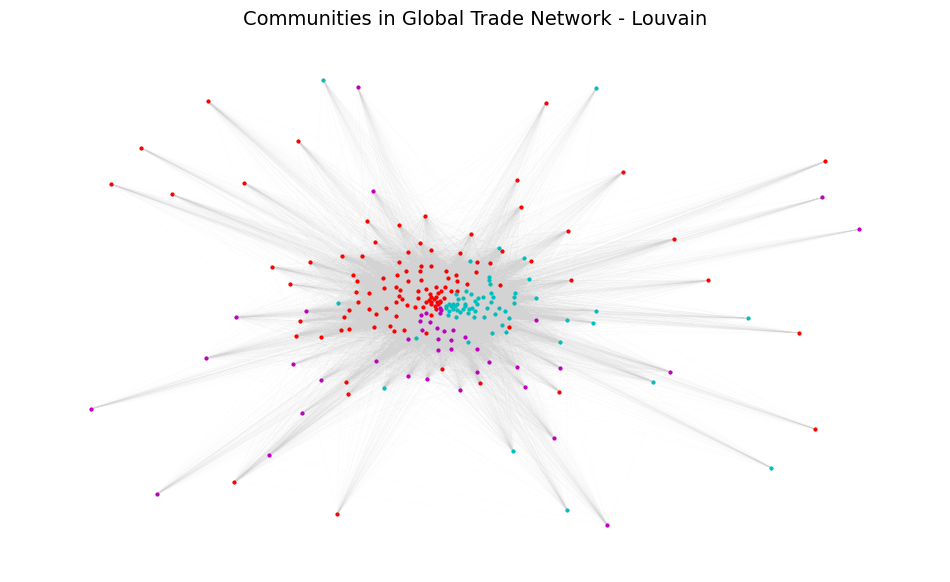

In [154]:
communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

pos = nx.spring_layout(G_undirected, k=20)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(G_undirected, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(G_undirected,
                       pos=pos,
                       edge_color='lightgray',
                       width=0.05,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm']
i=0
while i<3:
    nx.draw_networkx_nodes(G_undirected, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Communities in Global Trade Network - Louvain', fontsize=14)

plt.show()

In [38]:
deg = sorted(G_undirected.degree(weight='weight'), key=lambda pair: pair[1], reverse=True)

for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_10 = [country[0] for country in deg if country[0] in c][:10]
    print(f'community {i+1}:')
    for country in top_10:
        print(f'\t {country_code_dict[country]}')

community 1:
	 China
	 Japan
	 Rep. of Korea
	 Other Asia, nes
	 India
	 United Arab Emirates
	 Singapore
	 China, Hong Kong SAR
	 Saudi Arabia
	 Malaysia
community 2:
	 Germany
	 Netherlands
	 France
	 Italy
	 Belgium
	 United Kingdom
	 Spain
	 Russian Federation
	 Switzerland
	 Poland
community 3:
	 USA
	 Canada
	 Mexico
	 Brazil
	 Chile
	 Argentina
	 Peru
	 Colombia
	 Ecuador
	 Guatemala


## UK trade patterns

In [39]:
uk = 826

# Sense check - Subgraph for Vietnam and neighbours
G_sub = G.subgraph([uk] + list(G.neighbors(uk))).copy()
edges_to_remove = [(u, v) for u, v in G_sub.edges() if u != uk and v != uk] # remove edges between neighbours

G_sub.remove_edges_from(edges_to_remove)
print("Number of nodes in subgraph: ", G_sub.number_of_nodes())
print("Number of edges in subgraph: ", G_sub.number_of_edges())

Number of nodes in subgraph:  224
Number of edges in subgraph:  446


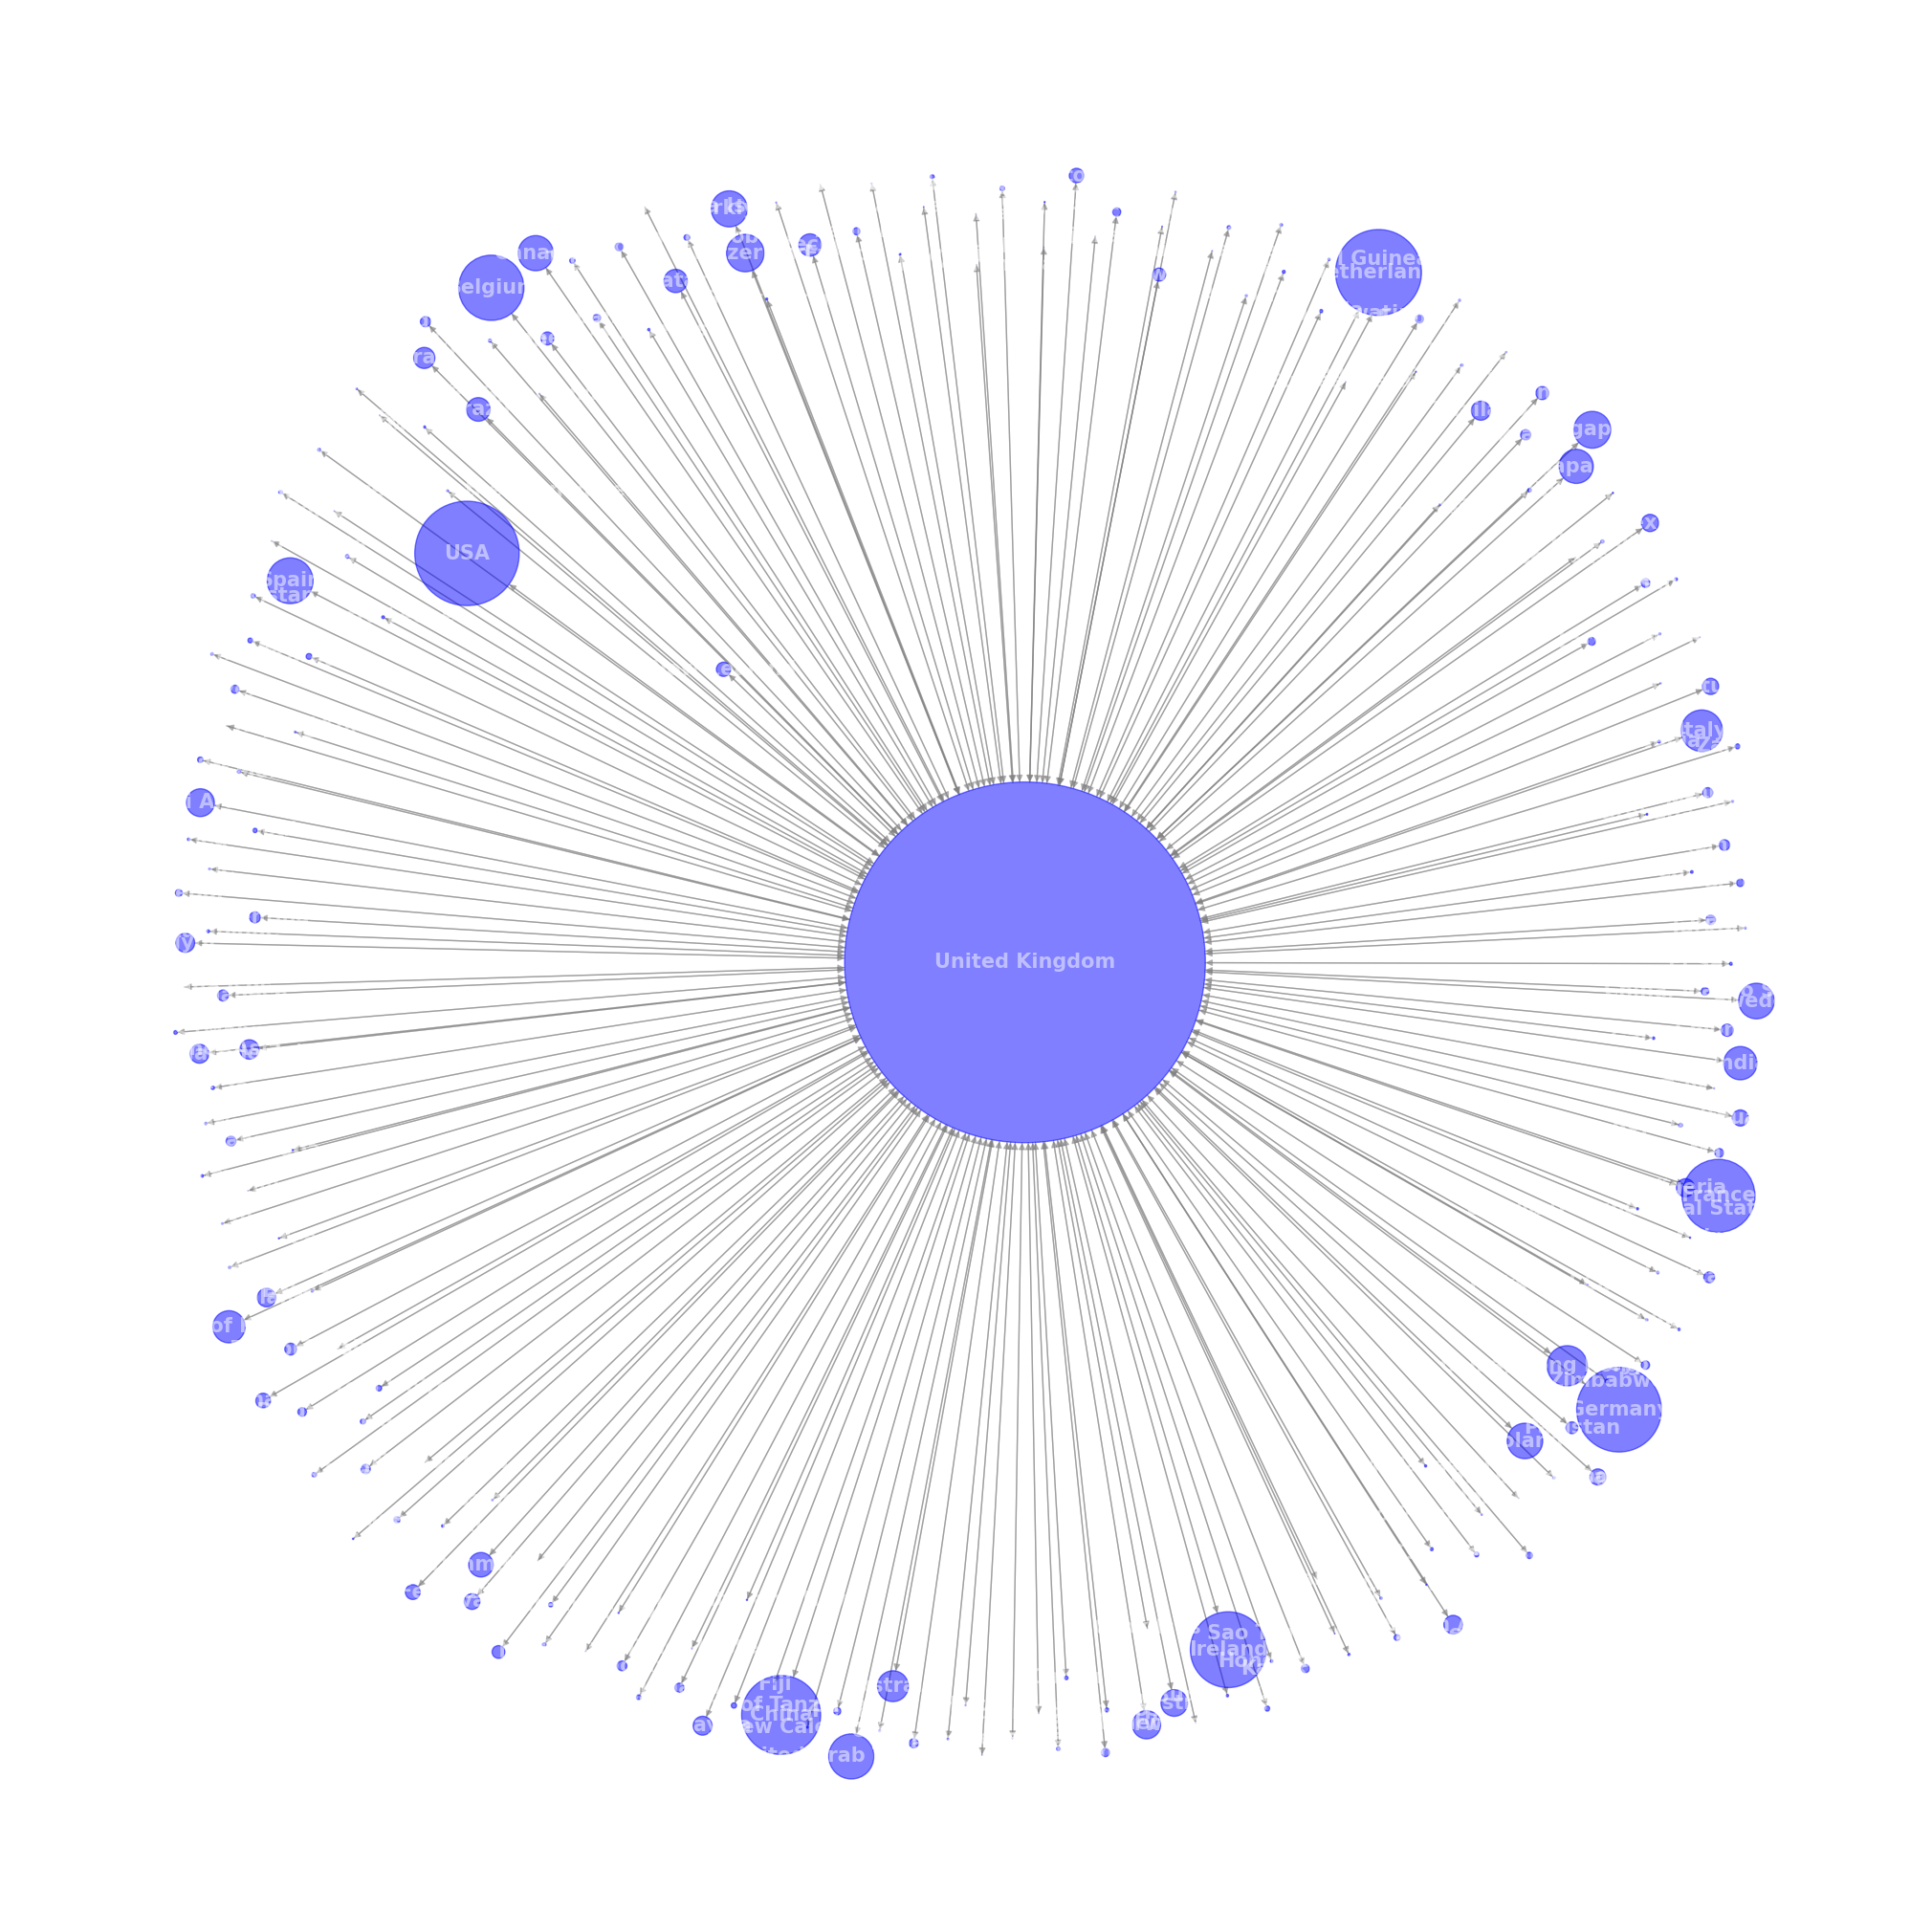

In [62]:
# Ego graph for UK
uk_ego = nx.ego_graph(G_sub, uk)
pos = nx.spring_layout(uk_ego, weight='weight', k=250,seed=42)

# Visualise the UK subgraph - Import                        
plt.figure(figsize=(20,20))
nx.draw(uk_ego,pos,with_labels=True, labels=nx.get_node_attributes(G_sub, 'country_name'), 
        font_size=15, node_size=[G_sub.in_degree(node, weight='weight')/10000 for node in G_sub.nodes()],
        node_color='blue', edge_color='gray',font_color='white', font_weight='bold', alpha=0.5)
plt.show()

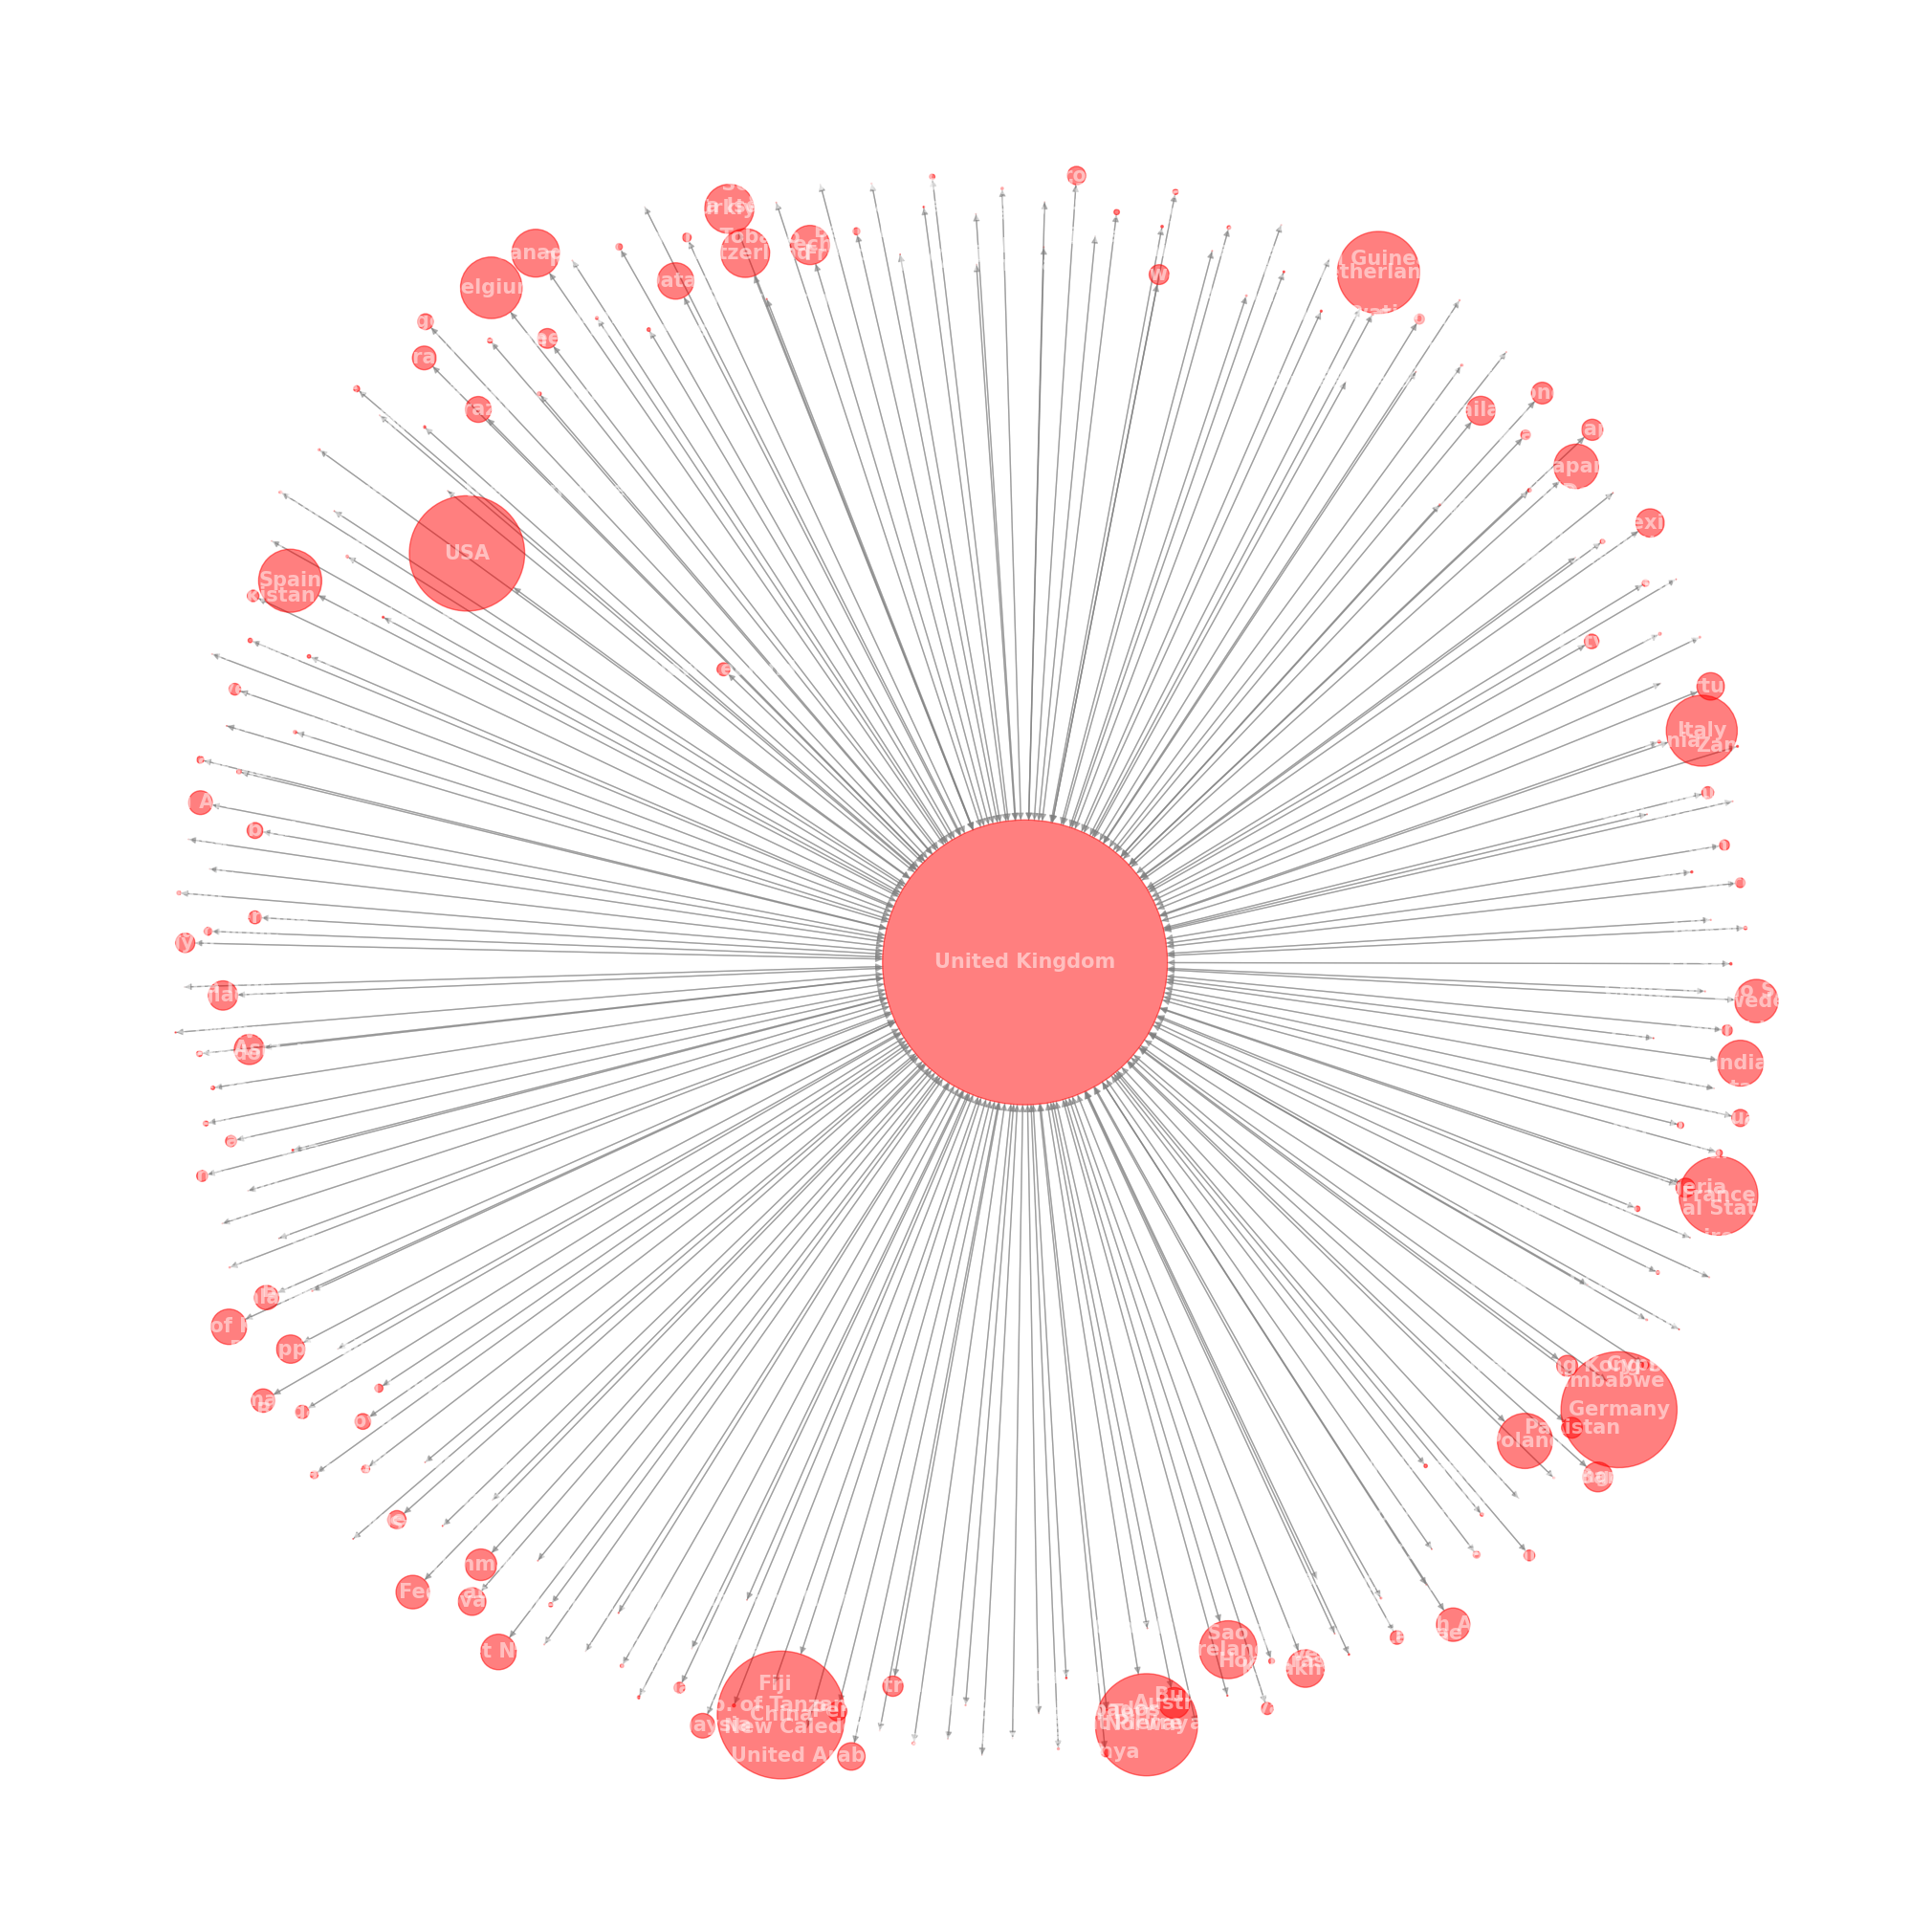

In [63]:
# Visualise the UK subgraph - Export                        
plt.figure(figsize=(20,20))
nx.draw(uk_ego,pos,with_labels=True, labels=nx.get_node_attributes(G_sub, 'country_name'), 
        font_size=15, node_size=[G_sub.out_degree(node, weight='weight')/10000 for node in G_sub.nodes()],
        node_color='red', edge_color='gray',font_color='white', font_weight='bold', alpha=0.5)
plt.show()

In [68]:
# Find top export partners (outgoing edges from UK)
exports = G_sub.out_edges(uk, data='weight')
sorted_exports = sorted(exports, key=lambda x: x[2], reverse=True)

uk_export_df = pd.DataFrame(sorted_exports, columns=['source', 'target', 'value'])
uk_export_df['exports to'] = uk_export_df['target'].map(country_code_dict)
uk_export_df['value (million USD)'] = round(uk_export_df['value']/1000)
uk_export_df = uk_export_df[['exports to', 'value (million USD)']]
uk_export_df.head(10)

exports to  value (million USD)
0                   USA              61818.0
1           Netherlands              41890.0
2               Germany              40623.0
3                 China              35380.0
4               Ireland              32585.0
5                France              30189.0
6               Belgium              24155.0
7                 Spain              11905.0
8  United Arab Emirates              11540.0
9                 Italy               9788.0

In [142]:
# Top products exported by UK to USA
usa = 842

df_uk_usa = df[(df['i'] == uk) & (df['j'] == usa)]
df_uk_usa.rename(columns={'k': 'code', 'v': 'value'}, inplace=True)
df_uk_usa.code=df_uk_usa.code.astype('string')
df_uk_usa = df_uk_usa.merge(product_df, left_on='code', right_on='code', how='left')

df_uk_usa = df_uk_usa[['description', 'value']]
df_uk_usa['description'] = df_uk_usa['description'].str.split(':').str[0]
df_uk_usa = df_uk_usa.sort_values(by='value', ascending=False)
df_uk_usa.head(10)

description        value
3580                                           Vehicles  3668370.660
907                                         Medicaments  3129907.019
512   Petroleum oils and oils from bituminous minera...  3028993.278
893   Toxins, cultures of micro-organisms (excluding...  2189151.986
3584                                           Vehicles  2022989.591
3651                            Aircraft and spacecraft  1921743.801
2898                                           Turbines  1709717.827
2893                                         Turbo-jets  1466990.207
405                                            Whiskies  1377611.708
3994                    Paintings, drawings and pastels  1274290.676

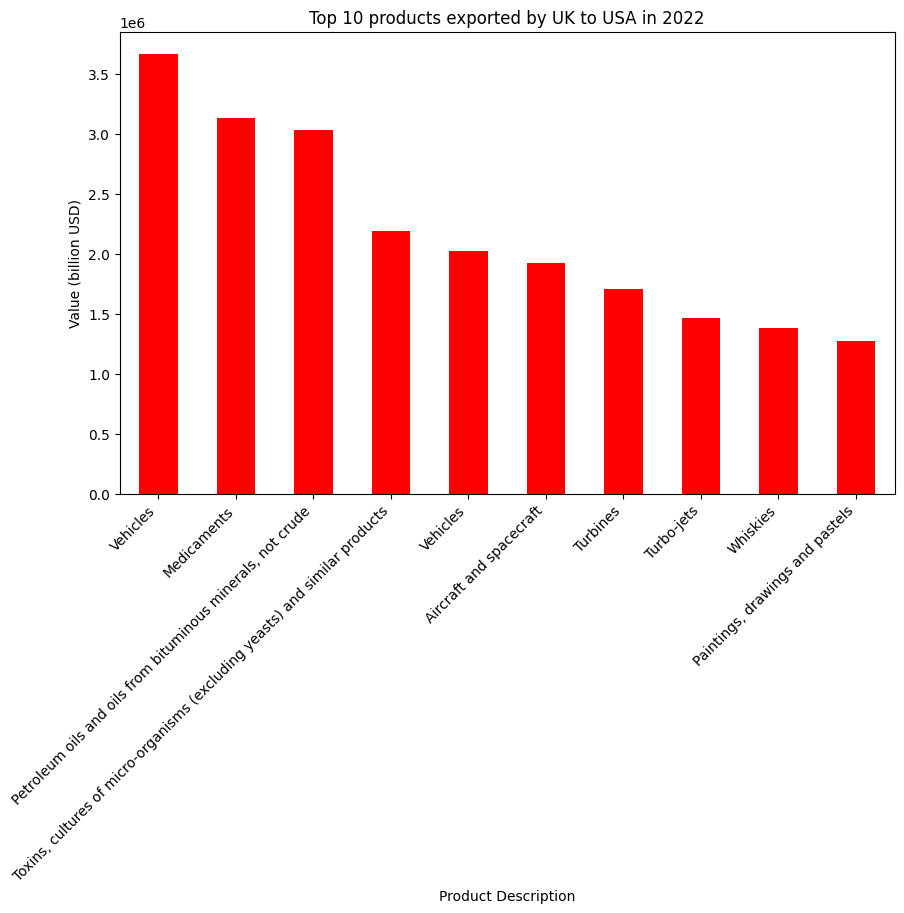

In [151]:
# visualise df_china_uk
fig, ax = plt.subplots(figsize=(10, 6))
df_uk_usa.head(10).plot(kind='bar', x='description', y='value', ax=ax, color='red', legend=False)
plt.title('Top 10 products exported by UK to USA in 2022')
plt.ylabel('Value (billion USD)')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha='right')
plt.show()

In [70]:
imports = G_sub.in_edges(uk, data='weight')
sorted_imports = sorted(imports, key=lambda x: x[2], reverse=True)

uk_import_df = pd.DataFrame(sorted_imports, columns=['source', 'target', 'value'])
uk_import_df['imports from'] = uk_import_df['source'].map(country_code_dict)
uk_import_df['value (million USD)'] = round(uk_import_df['value']/1000)
uk_import_df = uk_import_df[['imports from', 'value (million USD)']]
uk_import_df.head(10)

imports from  value (million USD)
0        China              92482.0
1      Germany              76193.0
2          USA              75360.0
3       Norway              59145.0
4  Netherlands              38197.0
5       France              35075.0
6        Italy              28511.0
7        Spain              22557.0
8      Belgium              21471.0
9      Ireland              19002.0

In [141]:
# Top products imported by UK from China
china = 156

df_china_uk = df[(df['i'] == china) & (df['j'] == uk)]
df_china_uk.rename(columns={'k': 'code', 'v': 'value'}, inplace=True)
df_china_uk.code=df_china_uk.code.astype('string')
df_china_uk = df_china_uk.merge(product_df, left_on='code', right_on='code', how='left')

df_china_uk = df_china_uk[['description', 'value']]
df_china_uk['description'] = df_china_uk['description'].str.split(':').str[0]
df_china_uk = df_china_uk.sort_values(by='value', ascending=False)
df_china_uk.head(10)

description        value
3310                          Data processing machinery  6673024.231
3500                             Transmission apparatus  6258811.532
3643                                           Vehicles  3725299.862
3317                                           Machines  2997755.133
3963                                               Toys  2110199.876
1210                                           Plastics  1750448.375
1092  Chemical products, preparations and residual p...  1621215.114
3967                                              Games  1563139.302
3428                              Electric accumulators  1246738.465
3588                  Electrical machines and apparatus   950877.288

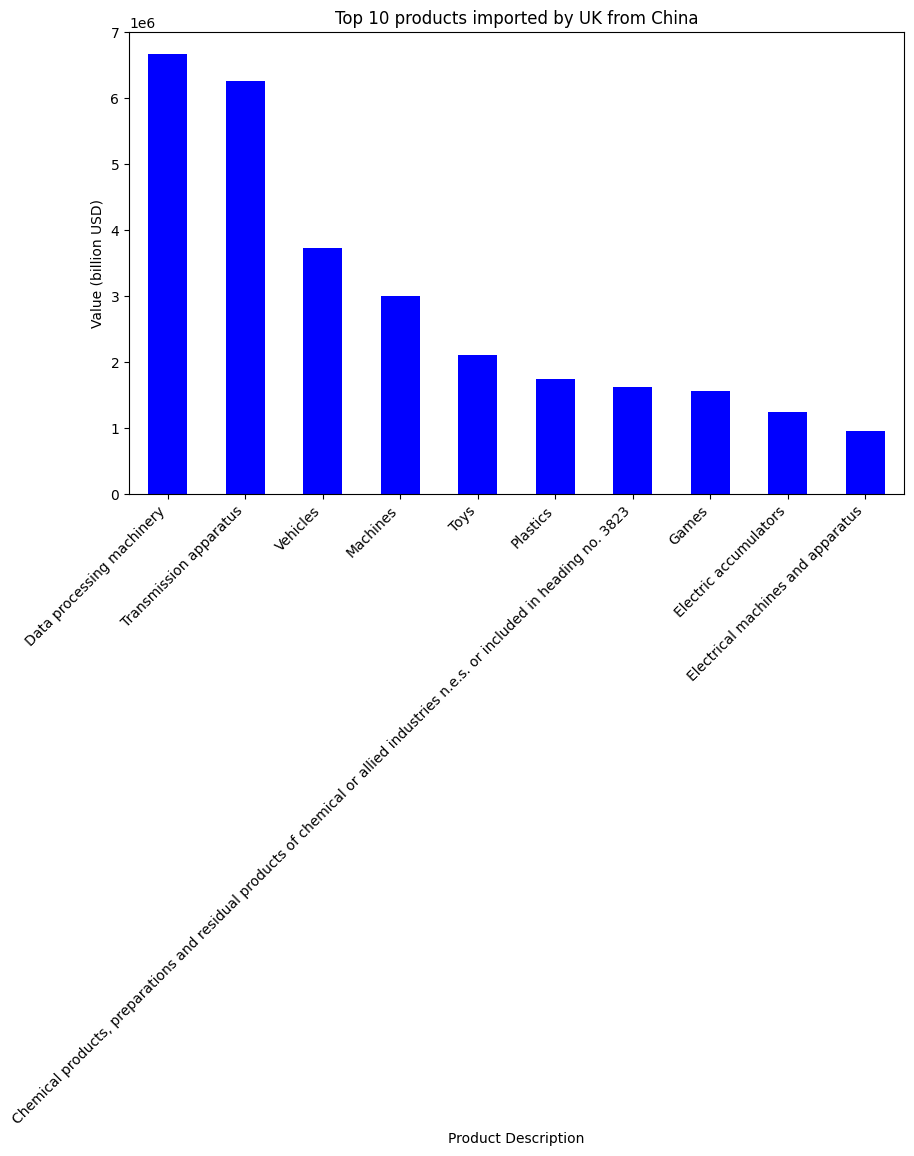

In [152]:
# visualise df_china_uk
fig, ax = plt.subplots(figsize=(10, 6))
df_china_uk.head(10).plot(kind='bar', x='description', y='value', ax=ax, color='blue', legend=False)
plt.title('Top 10 products imported by UK from China')
plt.ylabel('Value (billion USD)')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha='right')
plt.show()